#  Анализ данных об оптовых продажах аудиотехники

### Соберем датасет с заказами по папкам

Особенность входных данных состоит в том, что файлы для будущих датафреймов лежат разрозненно: в папке `orders` на каждую дату находится отдельная папка, внутри которой - папки отдельных менеджеров. В папке каждого менеджера находится по два csv-файла: `orders.csv` и `order_status.csv`. В папке `products` каждая под-папка посвящена одному виду аудиотехники, внутри каждой из этих папок - файл `products.csv`. Необходимо собрать три датафрейма на основе этих данных.

In [10]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
# установим настройки по умолчанию для будущих графиков
sns.set(
    font_scale =2,
    style      ="whitegrid",
    rc         ={'figure.figsize':(20,7)}
)

In [52]:
# обходим целевую папку с помощью модуля os и собираем датафреймы

root = '/Users/soiushka/analytical_projects/Audiotech_retail_project/data_for_audioproject'

target_files = ['orders.csv', 'order_status.csv', 'products.csv']
data_files = []

for path, dirs, files in os.walk(root):
    for file in files:
        if file in target_files:
            file_path = os.path.join(path, file)
            data_files.append(file_path)

df_orders = pd.DataFrame()
df_order_status = pd.DataFrame()
df_products = pd.DataFrame()

for i in data_files:
    if 'products' in i:
        products_to_read = pd.read_csv(i)
        products_to_read['category'] = i.split('/')[-2]
        df_products = pd.concat([df_products, products_to_read], ignore_index=True)
    elif '_status' in i:
        order_status_to_read = pd.read_csv(i)
        df_order_status = pd.concat([df_order_status, order_status_to_read], ignore_index=True)
    else:
        orders_to_read = pd.read_csv(i)
        orders_to_read['manager'] = i.split('/')[-2]
        orders_to_read['date'] = i.split('/')[-3]
        df_orders = pd.concat([df_orders, orders_to_read], ignore_index=True)

In [7]:
df_orders.head()

,order_id,product_id,quantity,manager,date
0,RJPI-21712323,473,5,Екатерина Тарелкина,2024-03-30
1,RJPI-21712323,229,3,Екатерина Тарелкина,2024-03-30
2,RJPI-21712323,799,15,Екатерина Тарелкина,2024-03-30
3,RJPI-21712323,624,40,Екатерина Тарелкина,2024-03-30
4,RJPI-21712323,513,13,Екатерина Тарелкина,2024-03-30


In [8]:
df_order_status.head()

,order_id,client_id,status
0,RJPI-21712323,22,confirmed
1,XRPC-48091227,52,confirmed
2,HCNJ-19162518,54,confirmed
3,ETDP-37053366,26,confirmed
4,MSXQ-45152143,61,confirmed


In [9]:
df_products.head()

,id,name,price,category
0,26,"Anker, Soundcore Liberty Neo",35.92,Беспроводные наушники
1,27,"Anker, Soundcore Life Q10",33.82,Беспроводные наушники
2,28,"Anker, Soundcore Liberty 2 Pro",126.79,Беспроводные наушники
3,29,"Anker, Soundcore Liberty Air",72.11,Беспроводные наушники
4,30,"Anker, Soundcore Liberty Air 2",86.96,Беспроводные наушники


### Посмотрим на общую динамику заказов и определим дни, которые выбиваются из общей картины

Посчитаем количество заказов в каждый день и определим день с наибольшим числом заказов.

In [67]:
df_orders['date'] = pd.to_datetime(df_orders['date'], format = '%Y-%m-%d')
orders_by_date = df_orders \
    .groupby('date', as_index = False) \
    .agg({'order_id':'nunique'}) \
    .rename(columns = {'order_id':'order_count'}) \
    .sort_values('order_count', ascending = False)

orders_by_date['days'] = orders_by_date['date'].dt.day_name()
orders_by_date.head(1)

,date,order_count,days
13,2024-03-14,34,Thursday


Видим, что 14 марта 2024 года, в четверг, было больше всего заказов.

Построим график с количеством заказов по дням и определим, заметна ли в данных сезонность.

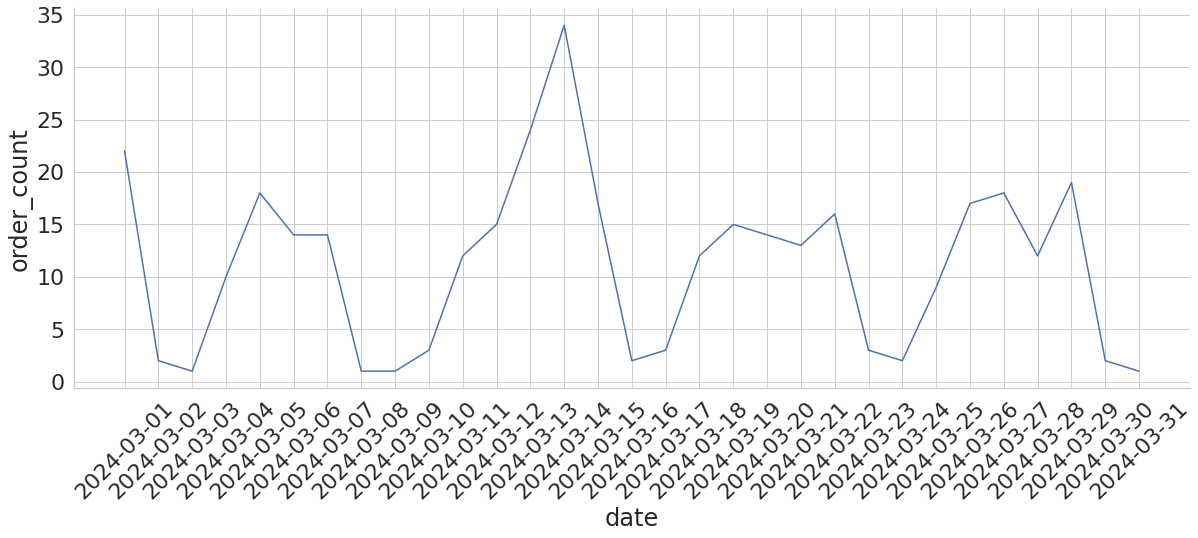

In [99]:
sns.lineplot(data = orders_by_date, x = 'date', y = 'order_count')
plt.xticks(rotation=45)
plt.xticks(orders_by_date["date"])
sns.despine()

Наблюдаем регулярность в динамике заказов: по выходным их почти нет. Также в данных заметен еще один аномальный день: 8 марта 2024 года, пятница. Обычно по пятницам у нас больше 10 заказов, но в эту - всего 1. Это может быть связано с тем, что это был выходной и праздничный день одновременно.

Но почему резко подскочили заказы 14 числа? Нужно подробнее изучить этот день. Начнем со статусов заказа.

Добавим к данным о заказах информацию об их статусах. Общий датафрейм назовем `orders_status`.

In [13]:
orders_status = df_orders.merge(df_order_status, on = 'order_id')
orders_status.head()

,order_id,product_id,quantity,manager,date,client_id,status
0,RJPI-21712323,473,5,Екатерина Тарелкина,2024-03-30,22,confirmed
1,RJPI-21712323,229,3,Екатерина Тарелкина,2024-03-30,22,confirmed
2,RJPI-21712323,799,15,Екатерина Тарелкина,2024-03-30,22,confirmed
3,RJPI-21712323,624,40,Екатерина Тарелкина,2024-03-30,22,confirmed
4,RJPI-21712323,513,13,Екатерина Тарелкина,2024-03-30,22,confirmed


Посмотрим на количество и соотношение подтвержденных и отмененных заказов.

In [14]:
orders_status.status.value_counts(normalize = True).round(2)

status
confirmed    0.89
canceled     0.11
Name: proportion, dtype: float64

Посчитаем количество подтвержденных и отмененных заказов на каждую дату. Определим, в какой день не было ни одного подтвержденного заказа. Для этого сделаем сводную таблицу, где в строках будут даты, в колонках — стутасы заказов, а значения — число заказов с этим статусом в определенную дату. Пропуски заполним нулями.

In [16]:
orders_status_df = orders_status \
    .groupby(['date', 'status'], as_index = False) \
    .agg({'order_id':'nunique'}) \
    .pivot(columns = 'status', index = 'date', values = 'order_id') \
    .fillna(0)

In [19]:
orders_status_df.query('confirmed == 0')

status,canceled,confirmed
date,,
2024-03-09,1.0,0.0


Видим, что ни одного заказа не было подтверждено 9 марта 2024 года.

Построим график с заказами по дням в разбивке по статусу заказа. Посмотрим подробнее на день с наибольшим числом заказов (вместе и подтвержденных, и отменных), который мы определили ранее, и на день, предшествующий ему.

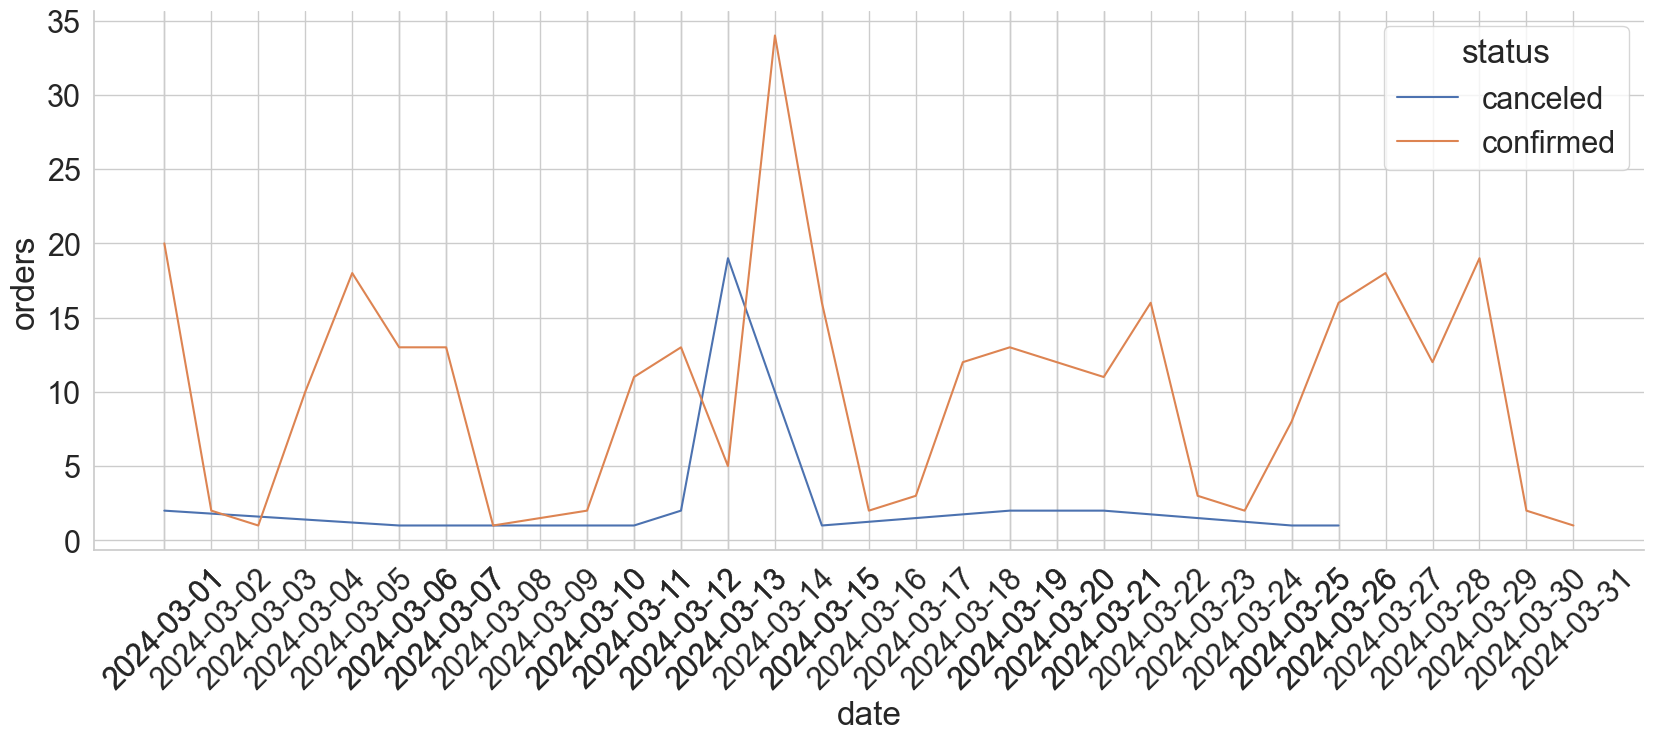

In [99]:
stats = orders_status \
    .groupby(['date', 'status'], as_index = False) \
    .agg({'order_id':'nunique'}) \
    .rename(columns={'order_id':'orders'})
#     .pivot(columns = 'status', index = 'date', values = 'orders', ) \
#     .fillna(0)

sns.lineplot(data = stats, x = 'date' , y = 'orders', hue = 'status')
plt.xticks(stats["date"], rotation=45)
sns.despine()

Видим, что в день с наибольшим числом заказов было много успешно оформленных заказов, а вот в день, предшествующий дню с наибольшим числом заказов, отмен было больше, чем подтверждений.

Наиболее правдоподобной будет гипотеза, что у нас произошел сбой в работе CRM системы, который не позволил клиентам подтвердить заказ. В результате все созданные в первый день заказы автоматически отменились, поэтому клиентам пришлось оформлять их повторно на следующий день, и почти половина заказов повторяет вчерашние.

Чтобы это проверить, сравним заказы, отмененные 13 числа, и заказы, подтвержденные 14-го. У них будут совпадать сразу несколько параметров: клиент, менеджер, количество уникальных товаров в заказе и общее число товаров в штуках. Но номера заказов будут разными.

In [100]:
cancelled_13 = orders_status \
    .query('date=="2024-03-13" and status == "canceled"') \
    .groupby('order_id',as_index=False) \
    .agg({'product_id':'nunique', 'quantity':'sum', 'manager':'max', 'client_id':'max'})

#cancelled_13

In [101]:
confirmed_14 = orders_status \
    .query('date == "2024-03-14" and status == "confirmed"') \
    .groupby('order_id',as_index=False) \
    .agg({'product_id':'nunique', 'quantity':'sum', 'manager':'max', 'client_id':'max'})

# confirmed_14

In [79]:
repeated_orders = cancelled_13.merge(confirmed_14, 
                  how = 'inner',
                  on = ['product_id', 'quantity', 'manager', 'client_id'])
repeated_orders

,order_id_x,product_id,quantity,manager,client_id,order_id_y
0,AFIH-00611801,11,192,Алексей Саксофонов,43,FDEB-71487438
1,BBFJ-27674101,14,294,Ксения Балалайкина,73,UETB-44283966
2,CLBQ-63032648,13,205,Виктор Тромбонов,60,IECD-18739530
3,CYJY-07359557,13,316,Екатерина Тарелкина,56,WNMY-98871151
4,GHGB-88045656,4,42,Ксения Балалайкина,7,JUGG-73806170
5,JEIF-69283221,15,207,Виктор Тромбонов,94,EPBF-14743479
6,JQQO-28609300,15,252,Виктор Тромбонов,93,OWZC-14247946
7,KJJS-03491897,18,399,Алексей Саксофонов,66,GRCH-73394464
8,MIGZ-68487439,17,325,Алексей Саксофонов,51,BCMM-97072924
9,NBIO-35476164,14,319,Виктор Тромбонов,95,NFML-87752700


Видим 14 таких заказов. Посмотрим на долю их от всех заказов, сделанных 14 марта.

In [80]:
len(repeated_orders) / len(confirmed_14)

0.47058823529411764

47 процентов заказов были сформированы повторно. Это значит, что новости скорее плохие: ничего эстраординарного 14 марта наш отдел продаж не сделал, а резкий скачок заказов обусловлен сбоем CRM-системы.

### Посчитаем ключевые метрики, посмотрим на их динамику и составим небольшой отчет

Вторая особенность наших данных состоит в том, что в них цена единицы товара указана в долларах США, а метрики требуется посчитать в рублях. В нашем распоряжении – отдельный текстовый файл с курсом доллара за определенный период на каждую дату. Откроем его и прочитаем в отдельный датафрейм.

In [81]:
usd_path = '/Users/soiushka/analytical_projects/Audiotech_retail_project/data_for_audioproject/usd_rate.txt'
usd_data = open(usd_path).readlines()

usd_df = pd.DataFrame()
usd_date_list = []
usd_currency_list = []

for i in usd_data:
    usd_date_list.append(i.split(',')[0])
    usd_currency_list.append(i.split(',')[1])
usd_df['date'] = usd_date_list
usd_df['currency'] = usd_currency_list

usd_df['currency'] = usd_df.currency.astype(float)
usd_df['date'] = pd.to_datetime(usd_df['date'], format = '%Y-%m-%d')
usd_df.head()

,date,currency
0,2024-03-01,90.8423
1,2024-03-02,91.3336
2,2024-03-03,91.3336
3,2024-03-04,91.3336
4,2024-03-05,91.3534


Объединим все датафреймы в общий `df_full` и посчитаем общую выручку в рублях (только по подтвержденным заказам).

In [82]:
df_products = df_products.rename(columns = {'id':'product_id'})
df_full = orders_status.merge(df_products, on = 'product_id')
df_full['date'] = pd.to_datetime(df_full['date'])

df_full = df_full.merge(usd_df, on = 'date')
df_full['revenue'] = df_full.price * df_full.currency * df_full.quantity

full_revenue = df_full.query("status == 'confirmed'").revenue.sum().round(2)
full_revenue

np.float64(2038231821.56)

Посчитаем средний чек.

In [43]:
avg_check = round(full_revenue / df_confirmed.order_id.nunique(), 2)
avg_check

np.float64(6596219.49)

Посмотрим на их динамику внутри месяца: построим графики выручки, среднего чека и числа заказов на каждый день. 

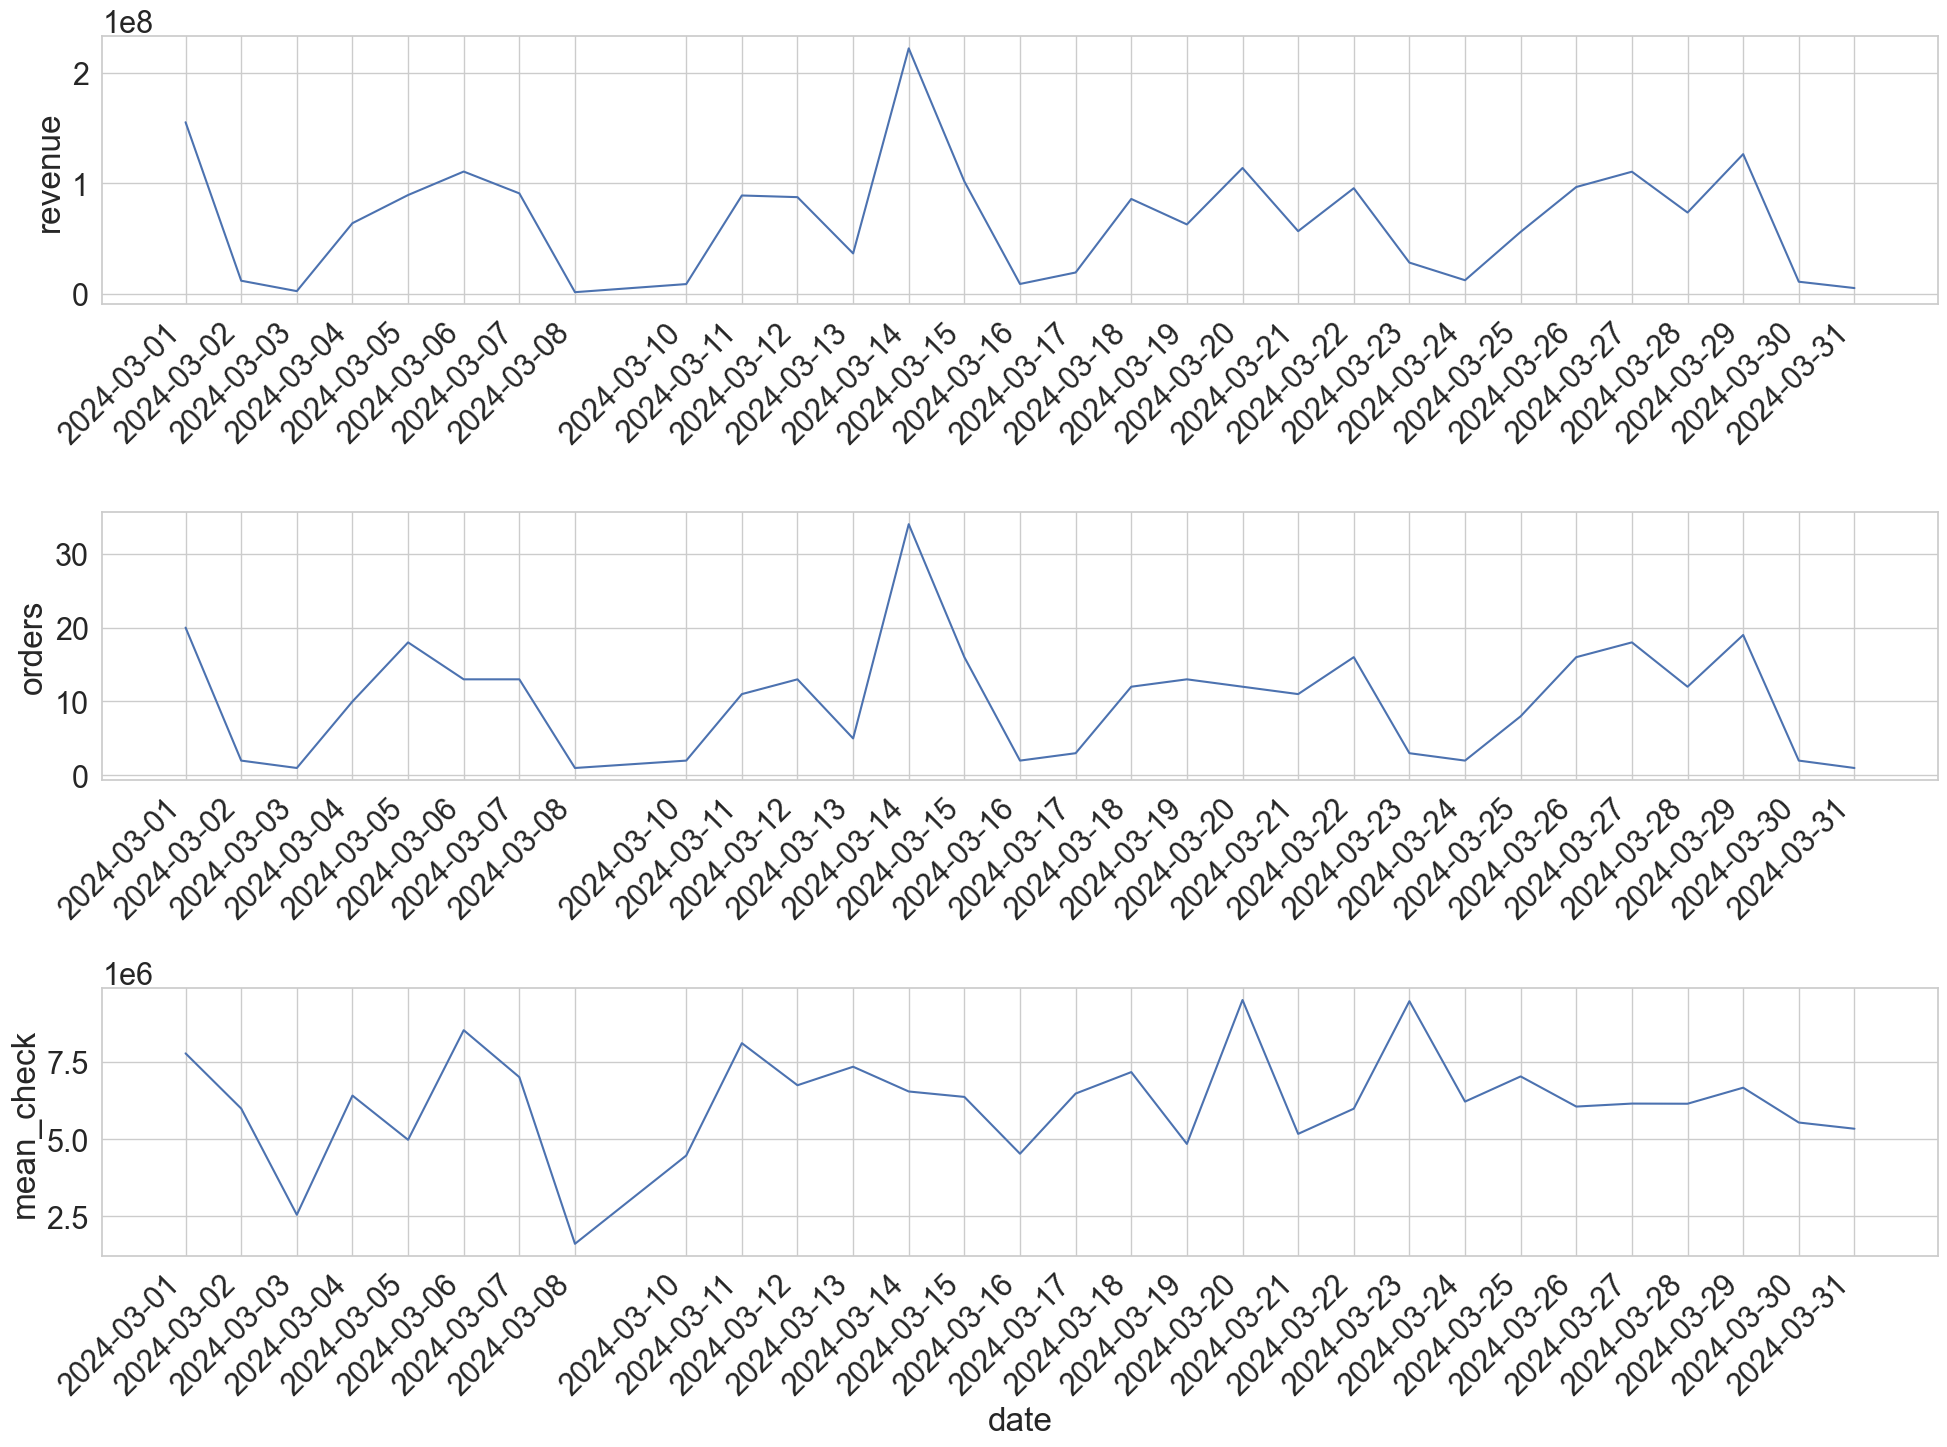

In [44]:
df_confirmed_by_day = df_confirmed \
    .groupby('date', as_index = False) \
    .agg({'revenue':'sum', 'order_id':'nunique'}) \
    .rename(columns = {'order_id':'orders'})

df_confirmed_by_day['mean_check'] = round(df_confirmed_by_day.revenue / df_confirmed_by_day.orders, 2)

plt.figure(figsize = (20, 15))

plt.subplot(311)
sns.lineplot(data = df_confirmed_by_day, x = 'date', y = 'revenue')
plt.xticks(df_confirmed_by_day["date"], rotation = 45, ha = 'right')
plt.xlabel('')
plt.tight_layout()

plt.subplot(312)
sns.lineplot(data = df_confirmed_by_day, x = 'date', y = 'orders')
plt.xticks(df_confirmed_by_day["date"], rotation = 45, ha = 'right')
plt.xlabel('')
plt.tight_layout()

plt.subplot(313)
sns.lineplot(data = df_confirmed_by_day, x = 'date', y = 'mean_check')
plt.xticks(df_confirmed_by_day["date"], rotation = 45, ha = 'right')
plt.tight_layout()


Видим следующие особенности динамики:
- число заказов и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день число заказов выросло, то выручка может упасть, и наоборот: число заказов упало — в этот же день выручка выросла)  
- средний чек и выручка не каждый день изменяются в одинаковом направлении (если в какой-то день средний чек вырос, то выручка может упасть, и наоборот: средний чек упал — в этот же день выручка выросла) 
- в день с наибольшим числом заказов выручка и/или средний чек не показывают максимальное значение  
- с течением времени выручка то увеличивается, то уменьшается  
- на протяжении всего месяца средний чек то увеличивается, то уменьшается  

### Проанализируем интерес клиентов к брендам

Теперь попробуем разобраться, какие бренды востребованы среди клиентов, а какие — нет. Для этого сформируем новую колонку.

In [86]:
df_full['brand'] = df_full.name.str.split(',').str[0]
df_full.head()

,order_id,product_id,quantity,manager,date,client_id,status,name,price,category,currency,revenue,brand
0,RJPI-21712323,473,5,Екатерина Тарелкина,2024-03-30,22,confirmed,"Heco, Concerto 3000",1720.72,Музыкальный центр,92.366,794680.11760,Heco
1,RJPI-21712323,229,3,Екатерина Тарелкина,2024-03-30,22,confirmed,"Denon, PMA-800NE",534.99,Интегральный усилитель,92.366,148244.65902,Denon
2,RJPI-21712323,799,15,Екатерина Тарелкина,2024-03-30,22,confirmed,"Klipsch, SPL-100",420.93,Сабвуфер,92.366,583194.30570,Klipsch
3,RJPI-21712323,624,40,Екатерина Тарелкина,2024-03-30,22,confirmed,"JBL, T450",25.21,Проводные наушники,92.366,93141.87440,JBL
4,RJPI-21712323,513,13,Екатерина Тарелкина,2024-03-30,22,confirmed,"Heco, Victa Sub 251A",225.34,Сабвуфер,92.366,270578.80772,Heco


In [88]:
# взглянем, сколько всего уникальных брендов представлено в данных
df_full.brand.nunique()

121

Определим, какой бренд принес наибольшую выручку.

In [89]:
df_full \
    .query("status == 'confirmed'") \
    .groupby('brand', as_index = False) \
    .agg({'revenue':'sum', 'order_id':'nunique'}) \
    .sort_values('revenue', ascending = False) \
    .head(1)

,brand,revenue,order_id
46,JBL,2.665961e+08,264


У одних брендов большинство товаров востребовано клиентами, а у других — клиенты заказывают только небольшую часть товаров, а остальные зря занимают виртуальную «полку» в перечне товаров. Необходимо определить, какие бренды редко попадают в заказы, хотя товаров таких брендов на самом деле много.

Начнем с того, что определим, сколько товаров ни разу не было заказано.

In [93]:
prod_id_list = list(df_confirmed.product_id.unique())

df_products['is_in_orders'] = df_products.product_id.isin(prod_id_list).replace({True:'yes', False:'no'})
df_products.is_in_orders.value_counts()

is_in_orders
yes    1180
no      497
Name: count, dtype: int64

Примерно треть товаров не была заказана ни разу. Посмотрим на эти данные в разрезе по брендам. Если доля ни разу не заказанных товаров у бренда была больше половины от всех продаваемых товаров, то будем считать, что они "простаивают". В расчеты не включим те бренды, которые представлены малым числом товаров (до 15).

In [97]:
df_products['brands'] = df_products.name.str.split(',').str[0]
all_brands = df_products \
    .groupby(['brands', 'is_in_orders'], as_index = False) \
    .agg({'product_id':'nunique'}) \
    .rename(columns = {'product_id':'products'}) \
    .pivot(columns = 'is_in_orders', index = 'brands', values = 'products') \
    .reset_index() \
    .fillna(0)

all_brands['items_sum'] = all_brands.no + all_brands.yes
big_brands = all_brands.query('items_sum > 15')

big_brands['ratio'] = round(big_brands.no / big_brands.items_sum, 2)
big_brands.loc[big_brands.ratio > 0.5]

/var/folders/b7/br4cg8q110g76cx0h7046qj00000gn/T/ipykernel_87963/3470268956.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  big_brands['ratio'] = round(big_brands.no / big_brands.items_sum, 2)


is_in_orders,brands,no,yes,items_sum,ratio
32,Dali,49.0,18.0,67.0,0.73
60,KEF,54.0,28.0,82.0,0.66
77,Marantz,19.0,3.0,22.0,0.86
94,Pioneer,70.0,33.0,103.0,0.68


### Составим отчет по продажам менеджеров

Для каждого менеджера посчитаем количество подтвержденных заказов и какую выручку они принесли, переведем расчеты в процентное соотношение к общему числу заказов и общей выручке, чтобы оценить вклад того или иного менеджера.

In [49]:
manager_performance = df_full[['order_id', 'manager', 'status', 'revenue']]

manager_perf_review = manager_performance \
    .groupby(['manager','status'], as_index = False) \
    .agg({'order_id':'nunique', 'revenue':'sum'}) \
    .query('status=="confirmed"') \
    .rename(columns = {'order_id':'orders'}) \
    .sort_values('revenue', ascending = False)

manager_perf_review['revenue_ratio'] = round(manager_perf_review.revenue / manager_perf_review.revenue.sum() * 100, 2)
manager_perf_review['orders_ratio'] = round(manager_perf_review.orders / manager_perf_review.orders.sum() * 100, 2)
manager_perf_review

,manager,status,orders,revenue,revenue_ratio,orders_ratio
18,Маргарита Камертонова,confirmed,48,3.473886e+08,17.04,15.53
8,Виктор Тромбонов,confirmed,50,3.188999e+08,15.65,16.18
16,Максим Барабанов,confirmed,40,2.401478e+08,11.78,12.94
10,Владимир Ударников,confirmed,31,2.084865e+08,10.23,10.03
1,Алексей Саксофонов,confirmed,27,1.953435e+08,9.58,8.74
14,Ксения Балалайкина,confirmed,27,1.817621e+08,8.92,8.74
12,Екатерина Тарелкина,confirmed,28,1.781576e+08,8.74,9.06
20,Надежда Гармошкина,confirmed,21,1.347836e+08,6.61,6.80
3,Анастасия Дудкина,confirmed,20,1.234504e+08,6.06,6.47
5,Антон Скрипкин,confirmed,7,5.150268e+07,2.53,2.27


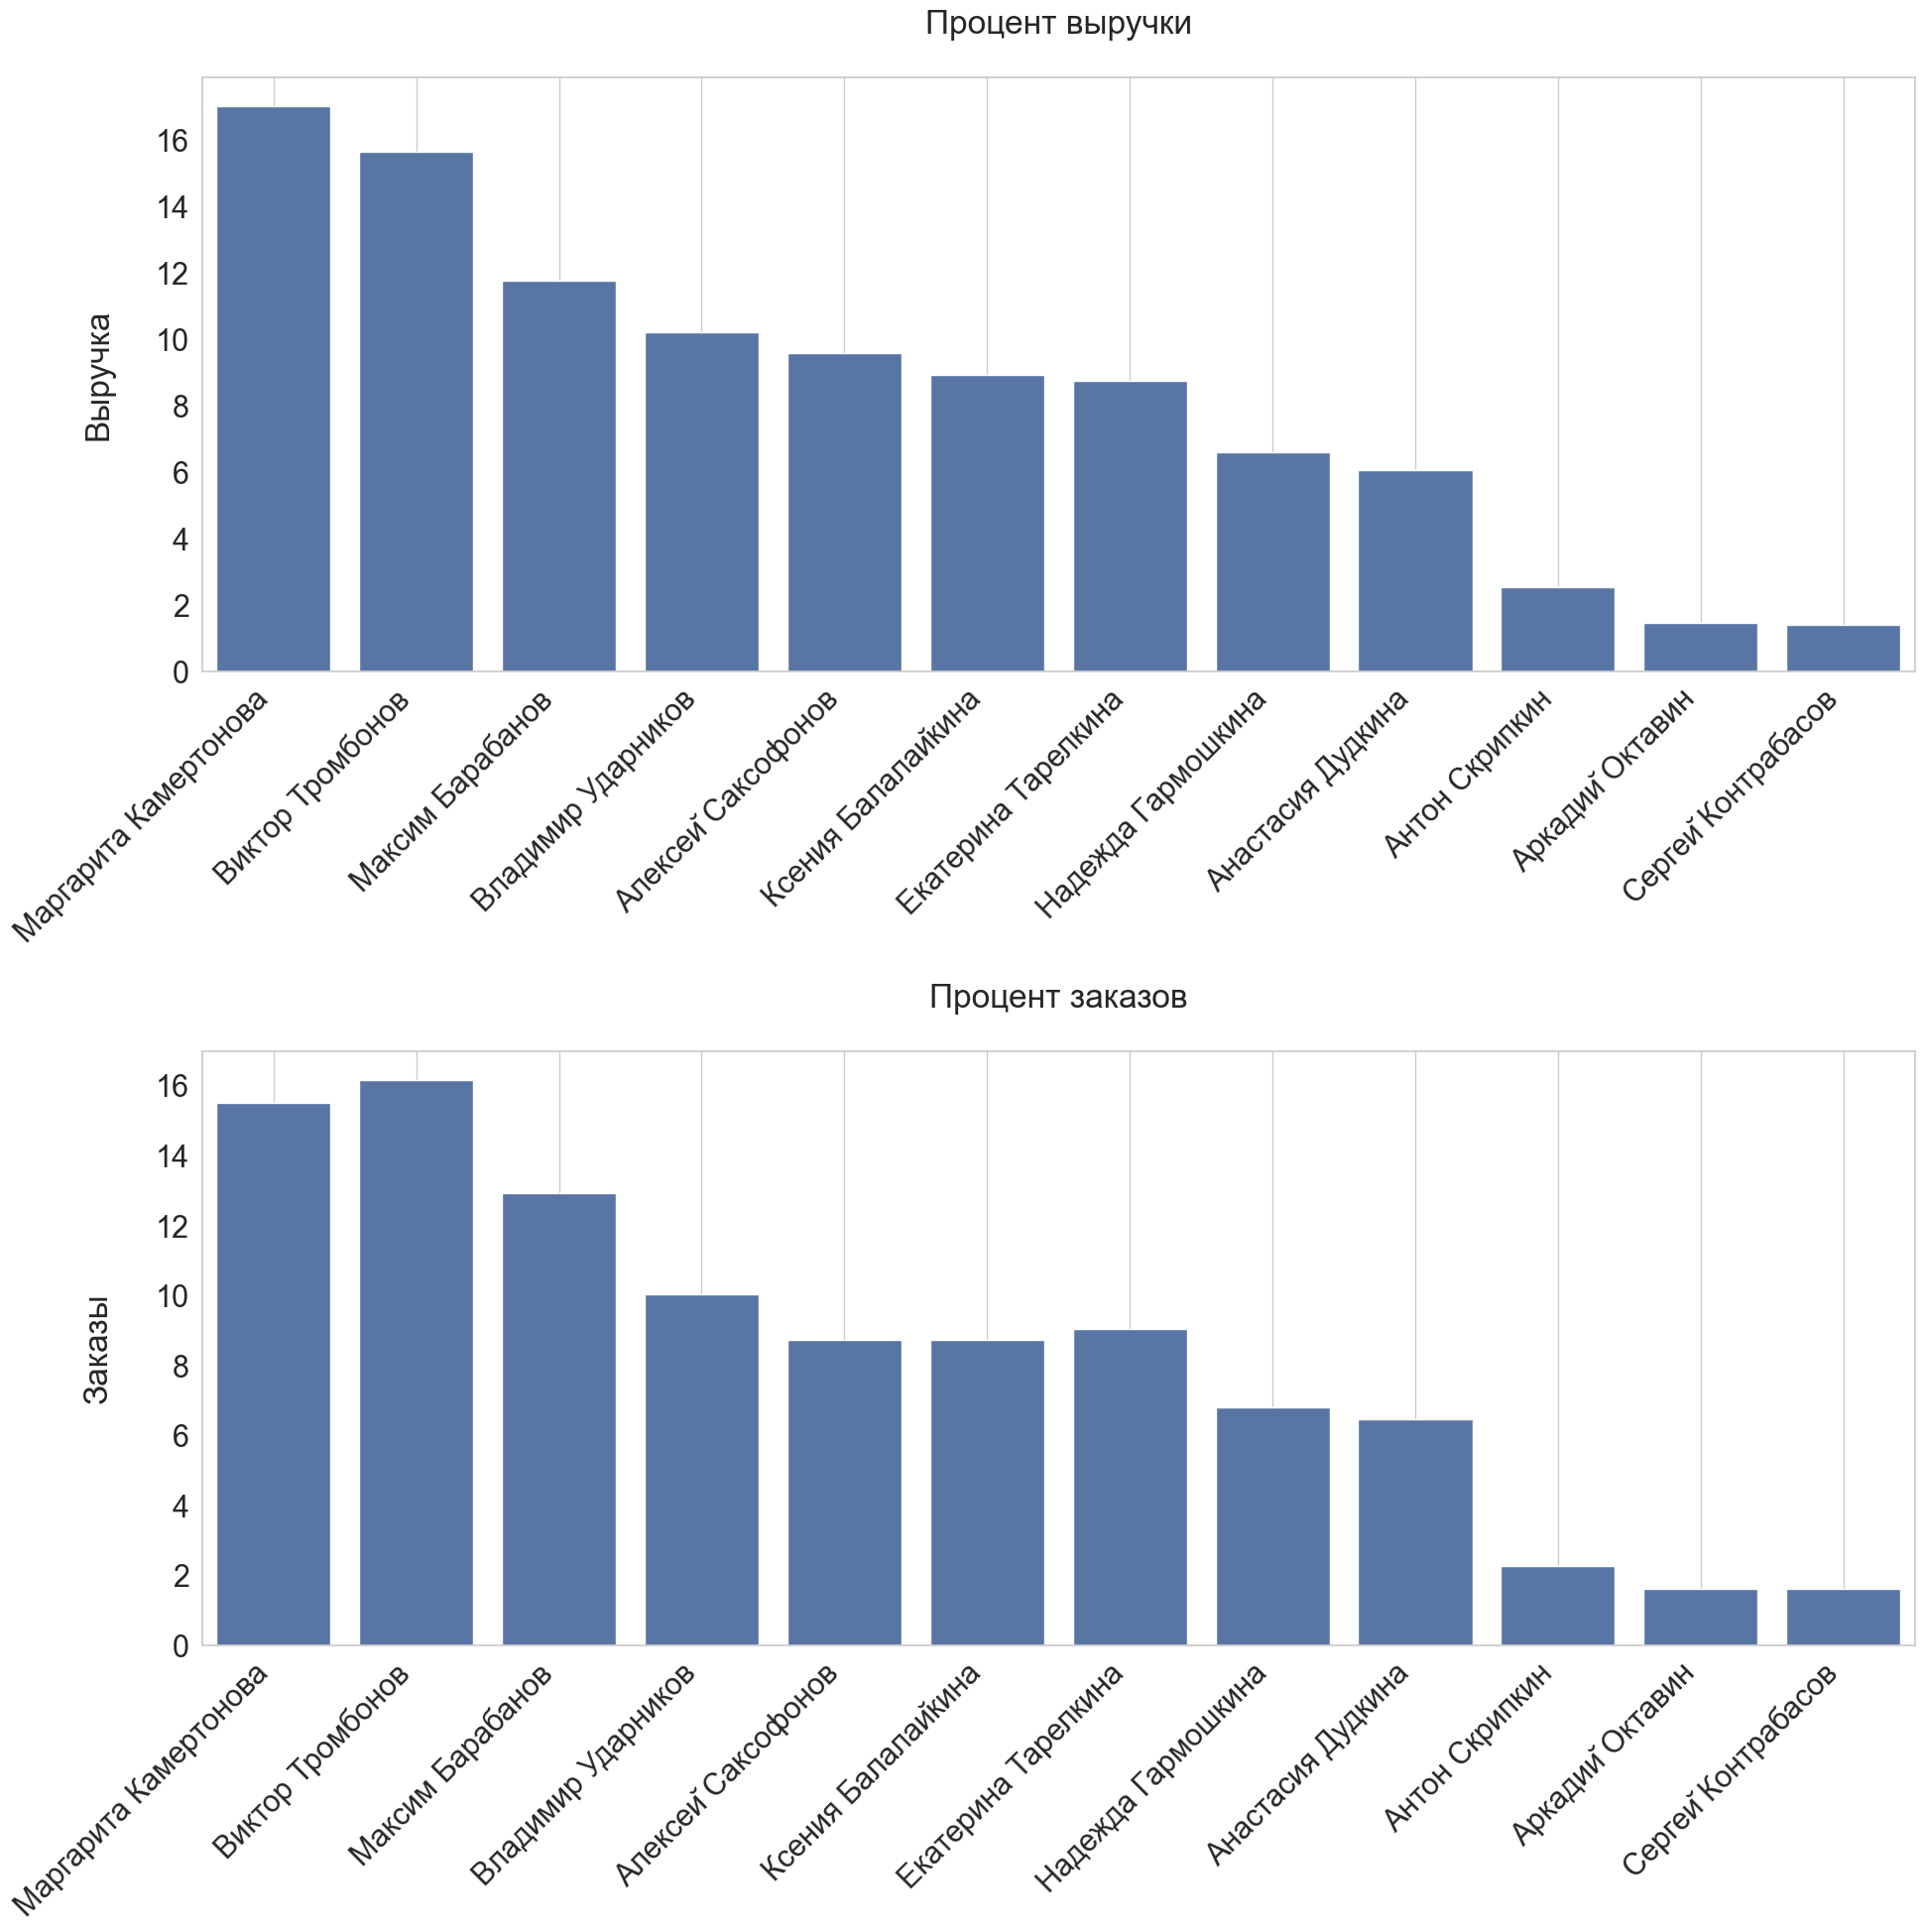

In [98]:
plt.figure(figsize = (20, 20))
plt.subplot(211)
sns.barplot(data = manager_perf_review, x = 'manager', y = 'revenue_ratio')
plt.title('Процент выручки\n')
plt.xlabel('')
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Выручка\n')
plt.grid()

plt.subplot(212)
sns.barplot(data = manager_perf_review, x = 'manager', y = 'orders_ratio')
plt.title('Процент заказов\n')
plt.xlabel('')
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Заказы\n')
plt.grid()

plt.tight_layout()

## Итоги

В проекте проанализированы продажи музыкальных товаров: собраны данные, посчитаны ключевые метрики в динамике; определены дни, которые выбиваются из общей картины, выдвинуты гипотезы о причинах этого; найдены наиболее прибыльные бренды и те, которые зря занимают место на виртуальной «полке».

Проанализированы продажи каждого менеджера и составлен отчет для СЕО.